In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision.transforms import v2

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_split import dagm_patch_get_splits
from src.deep_ad.image import plot_images
from src.deep_ad.model import DeepCNN
from src.deep_ad.trainer import define_loss_function
from src.deep_ad.transforms import create_training_transform, create_validation_transform

In [2]:
# Load the configuration
config = Config(root_dir="..")

### Test transforms

Load the split datasets without transforms for better control

In [18]:
from src.deep_ad.transforms import create_test_transform

transform = v2.Compose(
    [
        v2.RandomAffine(degrees=15, shear=(-15, 15, -15, 15), scale=(1, 1.1)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
    ]
)
full_transform = v2.Compose([transform, v2.CenterCrop(size=128)])
test_transform = create_test_transform()
train_dataset, val_dataset = dagm_patch_get_splits(config, train_transform=test_transform, val_transform=test_transform)

Plot a few transformed images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


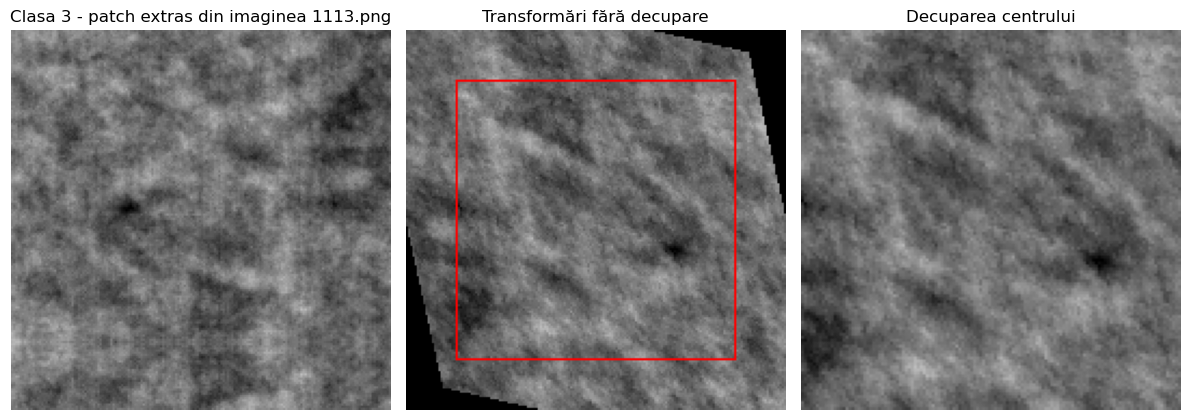

In [22]:
%matplotlib inline
import cv2 as cv
import numpy as np
import torch
from src.deep_ad.image import plot_images

def draw_center_rect(x: torch.Tensor) -> torch.Tensor:
    n = x.shape[1]
    x_np = cv.cvtColor(x.numpy().squeeze(), cv.COLOR_GRAY2RGB)
    x_np = cv.rectangle(
        x_np, (n // 2 - 128 // 2 - 1, n // 2 - 128 // 2 - 1), (n // 2 + 128 // 2, n // 2 + 128 // 2), (255, 0, 0), 1
    )
    return torch.from_numpy(x_np).permute(2, 0, 1)

def crop_center_rect(x: torch.Tensor) -> torch.Tensor:
    n = x.shape[1]
    return x[:, n // 2 - 128 // 2 : n // 2 + 128 // 2, n // 2 - 128 // 2 : n // 2 + 128 // 2]

images: list[np.ndarray] = []
titles: list[str] = []
num_images = 1
for i in range(num_images):
    img, key = train_dataset[i + 100]
    imgt = transform(img)
    images.extend(
        [
            img.numpy().squeeze(),
            draw_center_rect(imgt).permute((1, 2, 0)).numpy(),
            crop_center_rect(imgt).permute((1, 2, 0)).numpy().squeeze(),
            # full_transform(imgt).permute((1, 2, 0)).numpy().squeeze(),
        ]
    )
    cls, name, index = key.split("_")
    titles.extend([f"Clasa {cls} - patch extras din imaginea {name}.png", "Transformări fără decupare", "Decuparea centrului"])

plot_images(images, titles, rows=num_images, cols=3, figsize=(12, 9), show=False)
plt.savefig("transformari_patch.pdf", bbox_inches="tight")
plt.show()

### Test padding types

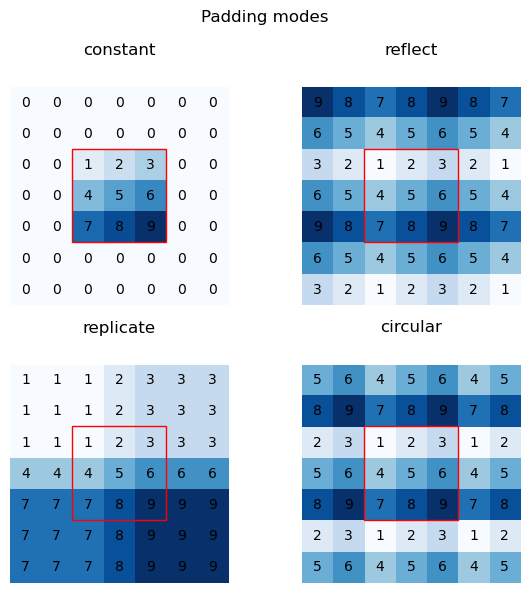

In [3]:
import matplotlib.pyplot as plt

from matplotlib.axes import Axes
from torch.nn.functional import pad


def img_heatmap(images: list[torch.Tensor], titles: list[str], rows: int, cols: int, figsize: tuple[int, int]):
    axs: np.ndarray
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        ax: Axes
        img, title = images[i], titles[i]
        ax.matshow(img, cmap=plt.cm.Blues)
        ax.axis("off")
        ax.set_title(title)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                c = int(img[j, i].item())
                ax.text(i, j, str(c), va="center", ha="center")
        # Draw a red rectangle over the center of the image
        ax.add_patch(plt.Rectangle((1.48, 1.48), 3.01, 3, edgecolor="red", fill=False))

    fig.suptitle("Padding modes")
    plt.tight_layout()
    plt.show()


img = torch.tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]], dtype=torch.float32)
pad_modes = ["constant", "reflect", "replicate", "circular"]
p = 2
images = [pad(img, (p, p, p, p), mode=mode).squeeze() for mode in pad_modes]
img_heatmap(images, pad_modes, rows=2, cols=2, figsize=(6, 6))

In [50]:
convs_dict: dict[str, nn.Conv2d] = {}
padding_modes = ["zeros", "reflect", "replicate", "circular"]
for mode in padding_modes:
    conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, padding_mode=mode)
    conv.weight.data.fill_(1)
    conv.bias.data.fill_(0)
    convs_dict[mode] = conv

image = torch.ones([1, 1, 5, 5])
image[0, 0, 1, 1] = 2
print(image[0, 0, :5, :5])
print(f"In shape: {image.shape}")
for mode, conv in convs_dict.items():
    image_conv = conv(image)
    print()
    print(f"{mode}: {image_conv.shape}")
    print(image_conv[0, 0, :5, :5])

tensor([[1., 1., 1., 1., 1.],
        [1., 2., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
In shape: torch.Size([1, 1, 5, 5])

zeros: torch.Size([1, 1, 5, 5])
tensor([[10., 13., 16., 13.,  9.],
        [13., 17., 21., 17., 12.],
        [16., 21., 26., 21., 15.],
        [13., 17., 21., 17., 12.],
        [ 9., 12., 15., 12.,  9.]], grad_fn=<SelectBackward0>)

reflect: torch.Size([1, 1, 5, 5])
tensor([[29., 29., 27., 27., 25.],
        [29., 29., 27., 27., 25.],
        [27., 27., 26., 26., 25.],
        [27., 27., 26., 26., 25.],
        [25., 25., 25., 25., 25.]], grad_fn=<SelectBackward0>)

replicate: torch.Size([1, 1, 5, 5])
tensor([[26., 26., 26., 26., 25.],
        [26., 26., 26., 26., 25.],
        [26., 26., 26., 26., 25.],
        [26., 26., 26., 26., 25.],
        [25., 25., 25., 25., 25.]], grad_fn=<SelectBackward0>)

circular: torch.Size([1, 1, 5, 5])
tensor([[26., 26., 26., 26., 26.],
        [26., 26., 26., 26., 

### Test network layers

In [104]:
# K, D, S, C_in, C_out, P
params = [
    (5, 1, 1, 3,  32, 2), # 1
    (3, 1, 1, 32, 64, 1), # 2
    (3, 1, 1, 64, 64, 1), # 3
    (3, 1, 2, 64, 128, 1), # 4
    (3, 1, 1, 128, 128, 1), # 5
    (3, 1, 1, 128, 128, 1), # 6
    (3, 2, 1, 128, 128, 2), # 7
    (3, 4, 1, 128, 128, 4), # 8
    (3, 8, 1, 128, 128, 8), # 9
    (3, 16, 1, 128, 128, 16), # 10
    (3, 1, 1, 128, 128, 1), # 11
    (3, 1, 1, 128, 128, 1), # 12
    (3, 1, 1, 128, 64, 1), # 13
    (3, 1, 1, 64, 64, 1), # 14
    (3, 1, 1, 64, 32, 1), # 15
    (3, 1, 1, 32, 16, 1), # 16
    (3, 1, 1, 16, 1, 1), # 17
]

image = torch.rand([3, 128, 128])
print(f"Input shape: {image.shape}")
for i, (k, d, s, c_in, c_out, p) in enumerate(params):
    if i == 12:
        upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        image = upsample(image.unsqueeze(0)).squeeze(0)
        print(f"{i+1:2d}. Upsample: {str(image.shape):26}")
    conv = nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=k, dilation=d, stride=s, padding=p, padding_mode='reflect')
    image = conv(image)
    print(f"{i+1:2d}. Conv({k}, {d:>2d}, {s}, {c_in:>3d}): {str(image.shape):26}, padding {p:>2d}")

Input shape: torch.Size([3, 128, 128])
 1. Conv(5,  1, 1,   3): torch.Size([32, 128, 128]), padding  2
 2. Conv(3,  1, 1,  32): torch.Size([64, 128, 128]), padding  1
 3. Conv(3,  1, 1,  64): torch.Size([64, 128, 128]), padding  1
 4. Conv(3,  1, 2,  64): torch.Size([128, 64, 64]) , padding  1
 5. Conv(3,  1, 1, 128): torch.Size([128, 64, 64]) , padding  1
 6. Conv(3,  1, 1, 128): torch.Size([128, 64, 64]) , padding  1
 7. Conv(3,  2, 1, 128): torch.Size([128, 64, 64]) , padding  2
 8. Conv(3,  4, 1, 128): torch.Size([128, 64, 64]) , padding  4
 9. Conv(3,  8, 1, 128): torch.Size([128, 64, 64]) , padding  8
10. Conv(3, 16, 1, 128): torch.Size([128, 64, 64]) , padding 16
11. Conv(3,  1, 1, 128): torch.Size([128, 64, 64]) , padding  1
12. Conv(3,  1, 1, 128): torch.Size([128, 64, 64]) , padding  1
13. Upsample: torch.Size([128, 128, 128])
13. Conv(3,  1, 1, 128): torch.Size([64, 128, 128]), padding  1
14. Conv(3,  1, 1,  64): torch.Size([64, 128, 128]), padding  1
15. Conv(3,  1, 1,  64)

### Test the network

#### Test the forward pass

In [4]:
# Load the datasets
train_transform = create_training_transform(config)
val_transform = create_validation_transform(config)
train_dataset, val_dataset, test_dataset = dagm_patch_get_splits(config, train_transform, val_transform)

In [5]:
# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [34]:
# Load the model
model = DeepCNN().to(config.device)
model_num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {model_num_params:,} parameters")

conv0_w = model.network[0].weight.data.clone()
conv0_b = model.network[0].bias.data.clone()
print(f"Conv0 wights mean: {torch.mean(conv0_w)}, weights std: {torch.std(conv0_w)}")

Model has 1,444,737 parameters
Conv0 wights mean: -0.0010208423482254148, weights std: 0.029319241642951965


batch_patches.shape: torch.Size([32, 1, 128, 128])
len(batch_labels): 32
input_image.shape: torch.Size([1, 1, 128, 128])
output_image.shape: torch.Size([1, 1, 128, 128])


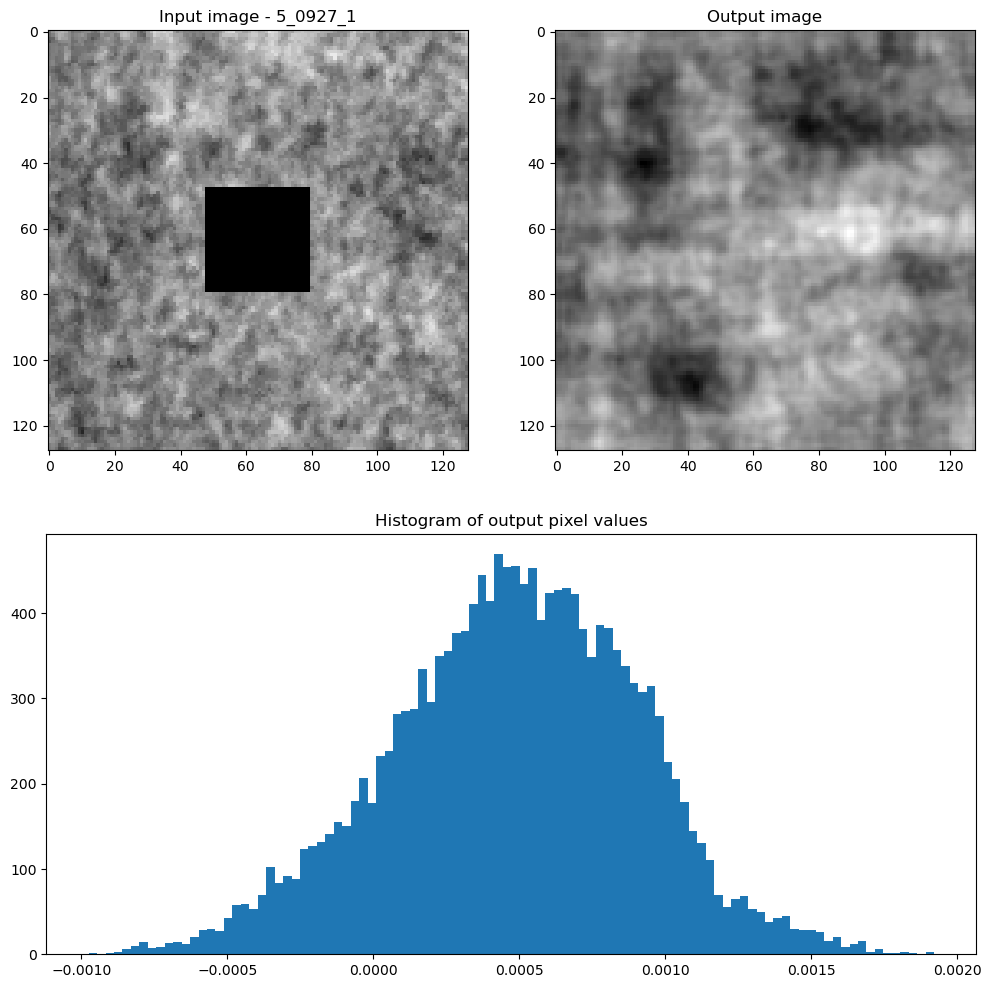

In [32]:
%matplotlib inline

# Load the first batch
first_batch = next(iter(train_dataloader))
batch_patches: torch.Tensor
batch_labels: list[str]
batch_patches, batch_labels = first_batch
batch_patches = batch_patches.type(torch.float32)
print(f"batch_patches.shape: {batch_patches.shape}")
print(f"len(batch_labels): {len(batch_labels)}")

# Feed the first image through the model
first_image: torch.Tensor = batch_patches[:1].to(config.device)
input_image: torch.Tensor = first_image.clone()
input_image[:, :, 48:80, 48:80] = 0
output_image: torch.Tensor = model(input_image)
print(f"input_image.shape: {input_image.shape}")
print(f"output_image.shape: {output_image.shape}")

# Plot the first image and its output
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(input_image[0, 0].detach().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
plt.title(f"Input image - {batch_labels[0]}")
plt.subplot(2, 2, 2)
plt.imshow(output_image[0, 0].detach().cpu().numpy(), cmap="gray")
plt.title("Output image")
plt.subplot(2, 1, 2)
plt.hist(torch.unique(output_image).detach().cpu().numpy(), bins=100)
plt.title("Histogram of output pixel values")
plt.show()

#### Test the loss function

tensor(0.0019, grad_fn=<AddBackward0>)
tensor([[0.0019]], grad_fn=<AddBackward0>)


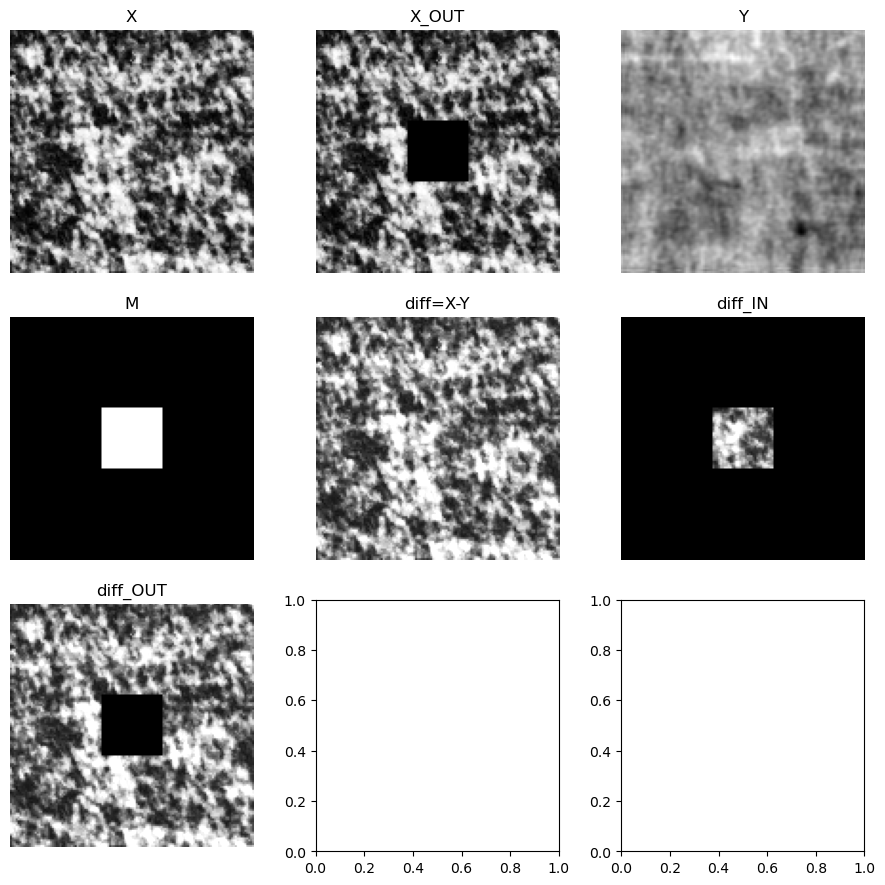

In [62]:
%matplotlib inline
predicted = output_image.cpu()  # 1 x 1 x 128 x 128
ground_truth = first_image.cpu() # 1 x 1 x 128 x 128

X = first_image.squeeze().cpu()
X_CUT = input_image.squeeze().cpu()
Y = output_image.squeeze().cpu()
M = torch.zeros(X.shape)
M[48:80, 48:80] = 1
M_ = 1 - M
N = X.numel()
Lambda = 0.9

diff = X - Y
diff_CUT = M * diff
diff_ICUT = (1 - M) * diff

loss = Lambda * torch.linalg.norm(diff_CUT, ord=1) / N + (1 - Lambda) * torch.linalg.norm(diff_ICUT) / N
lossv3 = define_loss_function(Lambda=Lambda, mask=M, N=N)(predicted, ground_truth)
print(loss)
print(lossv3)

images = [x.detach().numpy() for x in [X, X_CUT, Y, M, diff, diff_CUT, diff_ICUT]]
plot_images(images, ["X", "X_OUT", "Y", "M", "diff=X-Y", "diff_IN", "diff_OUT"], rows=3, cols=3, figsize=(9, 9))